In [13]:
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

fred = Fred(api_key='d59606a150e09c54fd5158bac863da0d')

# dataset

In [14]:
def FRED_get_series(id, name=None, df=None):
    series = fred.get_series(id)
    if name is not None:
        series = series.rename(name)
    if df is None:
        return series
    if isinstance(df, (pd.DataFrame, pd.Series)):
        df = pd.concat([df,series], axis=1)
        return df
    else:
        raise ValueError("df should be either a DataFrame or a Series")
    
class fred_series:
    def __init__(self, name, id, frequency, description):
        self.name = name
        self.id = id
        self.description = description
        self.frequency = frequency

In [15]:
vars = {
    'unem' : fred_series('unemployment', 'UNRATE', 'Monthly', 'Unemployment Rate'),
    '1y_yield' : fred_series('1y_yield', 'DGS1', 'Daily', 'Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis '),
    '10y_yield' : fred_series('10y_yield', 'DGS10', 'Daily', 'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis '),
    # 'ppi' : fred_series('ppi','PPIACO', 'Monthly', 'Producer Price Index by Commodity: All Commodities' ),
    # 'gdp' : fred_series('gdp','GDP', 'Quarterly', 'Gross Domestic Product'),
    'pce' : fred_series('pce', 'PCE', 'Monthly', 'Personal Consumption Expenditures'),
    'cpi' : fred_series('cpi', 'CPIAUCSL', 'Monthly', 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average'),
    # 'population' : fred_series('population', 'POPTHM', 'Monthly', 'Population Level'),
    'stocks' : fred_series('stocks', 'SPASTT01USM657N', 'Monthly', 'Share Prices: All Shares/Broad: Total for United States'),
    # 'budget' : fred_series('budget', 'FYFSGDA188S', 'Annual', 'Federal Surplus or Deficit [-] as Percent of Gross Domestic Product'),
    'credit' : fred_series('credit', 'LOANS', 'Monthly', 'Loans and Leases in Bank Credit, All Commercial Banks'),
    'ind_loans' : fred_series('ind_loans', 'BUSLOANS', 'Monthly', 'Commercial and Industrial Loans, All Commercial Banks'),
}

In [16]:
df = pd.DataFrame()
for i in vars.values():
    df = FRED_get_series(i.id, i.name, df)
    
df = df.set_index(pd.to_datetime(df.index))
#df = df.fillna(method='ffill')
df = df.loc[(df.index >= pd.Timestamp(1962, 1, 1)) & (df.index <= pd.Timestamp(2023, 10, 1))]
df['yield_spread'] = df['10y_yield'] - df['1y_yield']

# df = df.drop(['gdp', 'pce'], axis=1)
df = df.resample('M').median()
# df['gdp'] = df['gdp'].fillna(method='ffill')
# df['gdp_pop'] = df['gdp'] / df['population']
df['pce'] = df['pce'] / df['cpi']
df['ind_loan_ratio'] = df['ind_loans'] / df['credit']
df['credit'] = df['credit'] / df['cpi']
df['stocks'] = df['stocks'] / df['cpi']
# df = df.drop('population', axis=1)

dfp = pd.concat([df.drop('stocks', axis=1).pct_change(), df['stocks']/100], axis=1).dropna()


/var/folders/_3/rnpxztfs6yj0szzqfjfw3vxc0000gn/T/ipykernel_66375/2650334007.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  dfp = pd.concat([df.drop('stocks', axis=1).pct_change(), df['stocks']/100], axis=1).dropna()


In [17]:
dfp.to_parquet('US-economy.parquet')

In [18]:
pip install fastparquet

Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install pyarrow

  Using cached pyarrow-13.0.0.tar.gz (1.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pyarrow (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [328 lines of output]
      <string>:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      WARNING setuptools_scm.pyproject_reading toml section missing 'pyproject.toml does not contain a tool.setuptools_scm section'
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-cpython-312
      creating build/lib.macosx-11.0-arm64-cpython-312/pyarrow
      copying pyarrow/orc.py -> build/lib.macosx-11.0-arm64-cpython-312/pyarrow
      copying pyarrow/conftest.py -> build/lib.macosx-11.0-arm64-cpython-312/pyarrow
      copying py

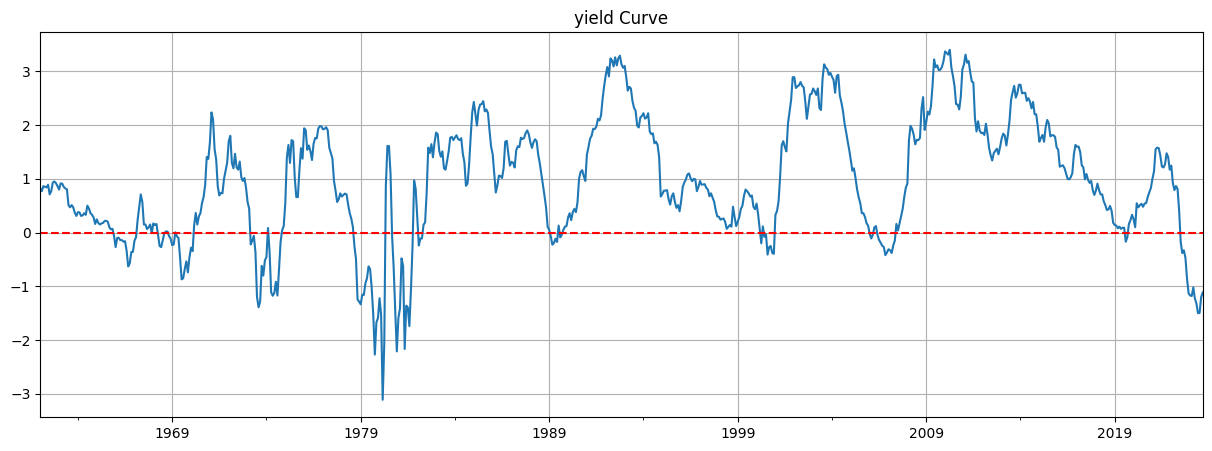

In [20]:
df['yield_spread'].plot(figsize=(15,5))
plt.axhline(0, c='r', linestyle='--')
plt.grid(True)
plt.title('yield Curve')
plt.show()

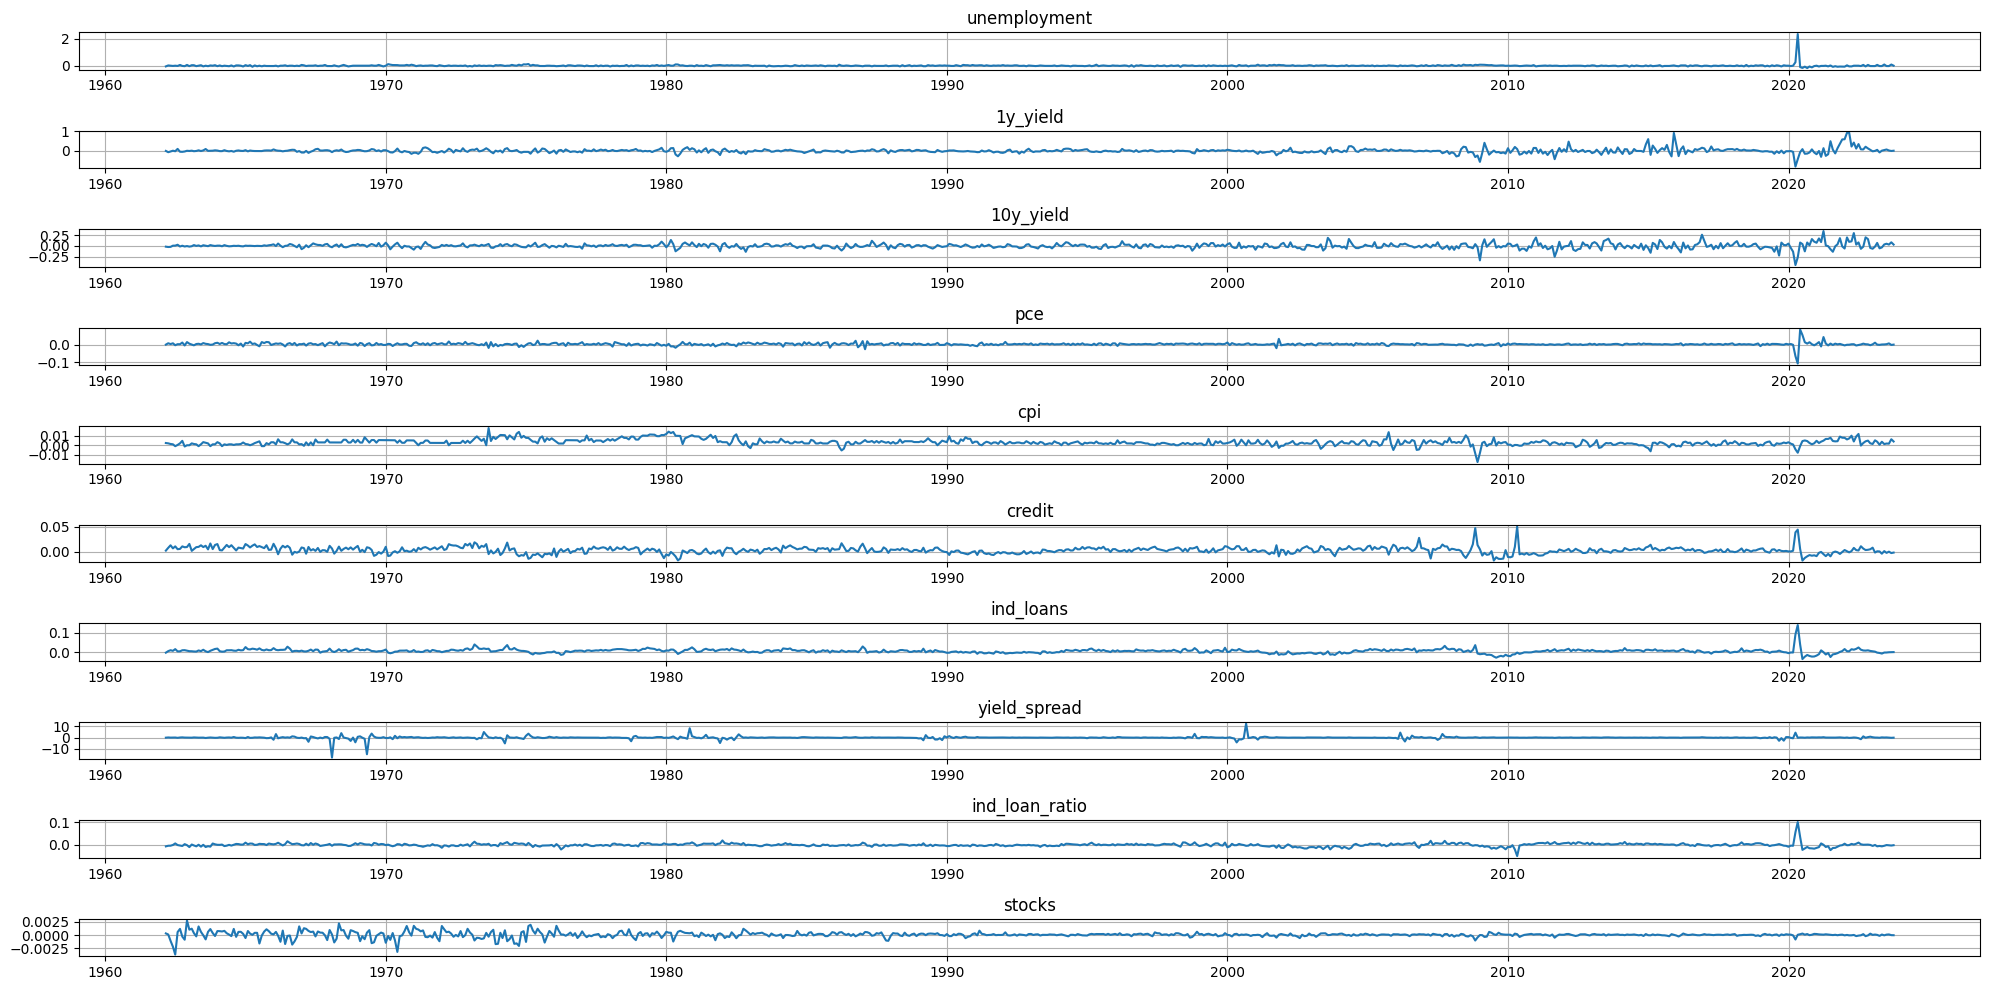

In [21]:
# Plot each time series in a separate subplot
fig, axes = plt.subplots(nrows=len(dfp.columns), ncols=1, figsize=(20, 10))

for i, column in enumerate(dfp.columns):
    axes[i].plot(dfp.index, dfp[column])
    axes[i].set_title(column)
    axes[i].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

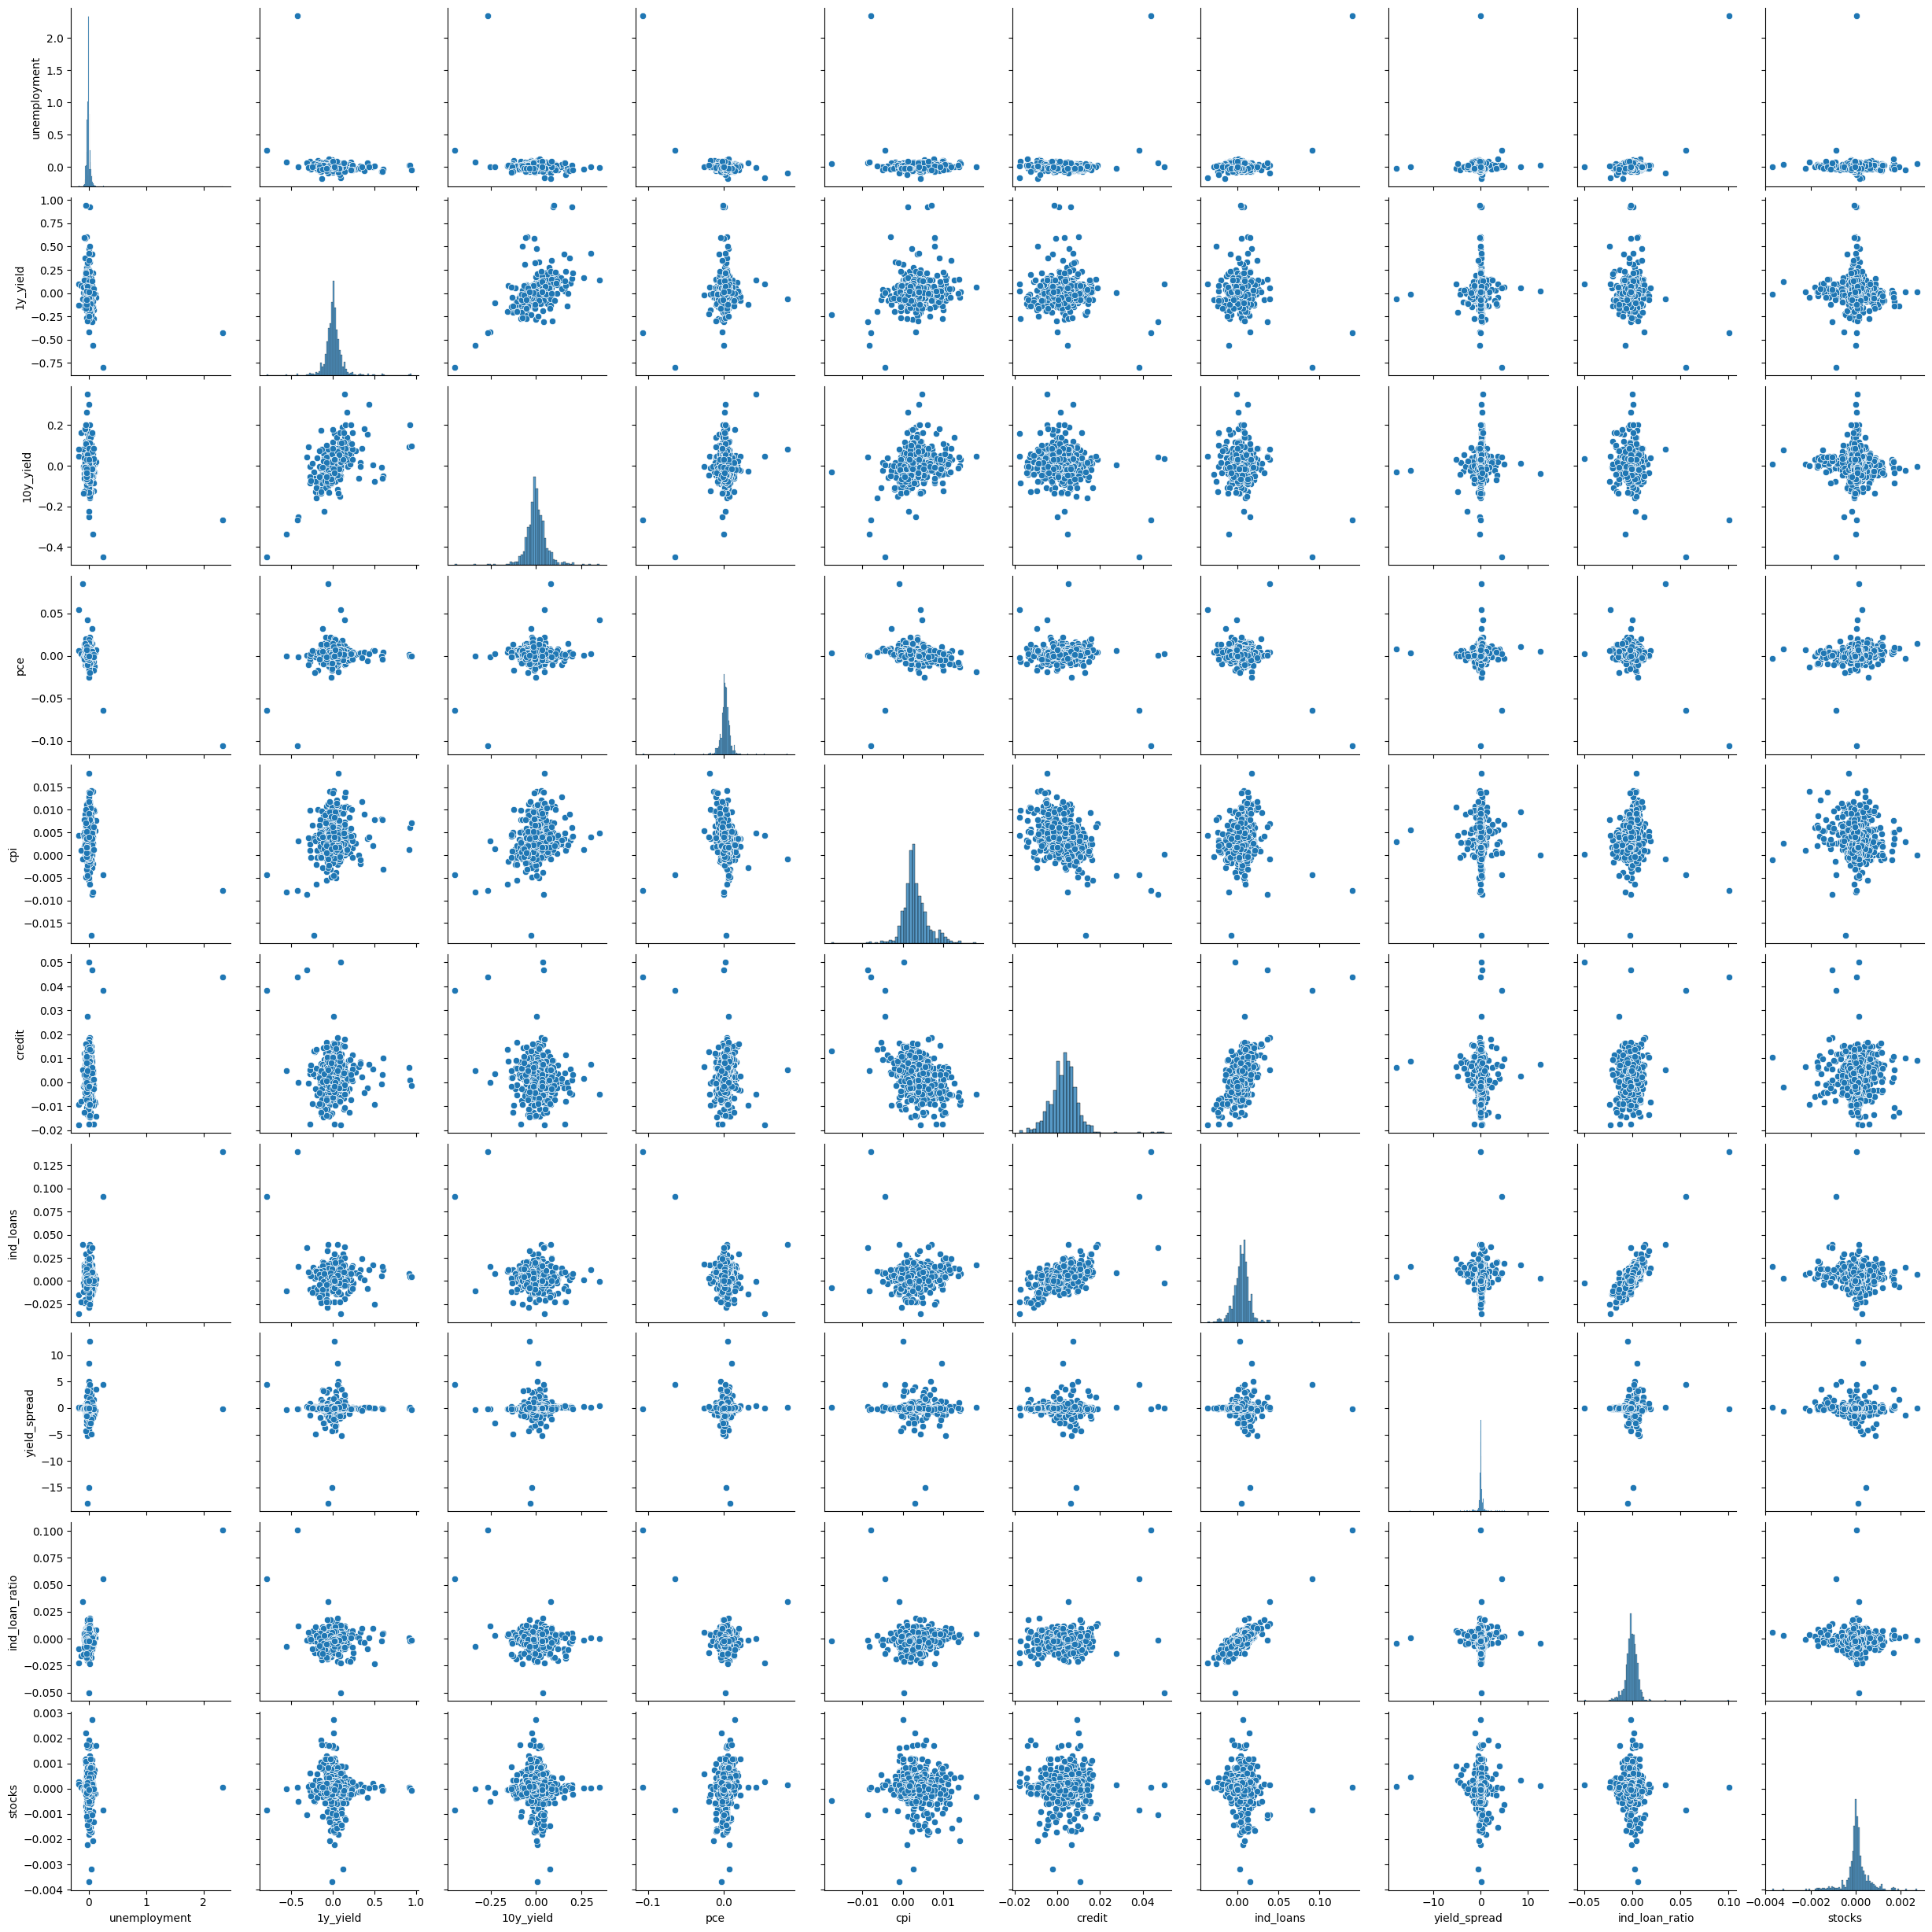

In [22]:
sns.pairplot(dfp)
plt.show()

In [23]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go

In [24]:
scaler = StandardScaler(with_std=True)
cols = df.columns
scaled_df = pd.DataFrame(scaler.fit_transform(dfp),columns=cols,index=dfp.index)
scaled_df = scaled_df.dropna()
scaled_df

,unemployment,1y_yield,10y_yield,pce,cpi,stocks,credit,ind_loans,yield_spread,ind_loan_ratio
1962-02-28,-0.577159,-0.040704,-0.317249,-0.285913,-0.259269,-0.141000,-0.785695,-0.024770,-0.866002,0.475096
1962-03-31,0.180716,-0.592935,-0.446505,0.654601,-0.365624,0.702907,-0.034775,0.122705,-0.509161,0.085177
1962-04-30,-0.016400,-0.280351,-0.393315,0.108356,-0.575754,1.459514,0.404433,0.013507,-0.467945,-2.206748
1962-05-31,-0.209995,0.044218,0.076410,0.625079,-0.680609,0.538883,0.104292,0.017834,-0.040379,-4.347691
1962-06-30,-0.016400,-0.174526,0.097282,-0.699124,-1.306112,1.139311,0.941069,0.073155,0.863792,-7.195448
...,...,...,...,...,...,...,...,...,...,...
2023-05-31,0.940190,0.296979,0.551179,-0.136350,-0.602399,-0.285627,-0.733844,0.087144,-0.523600,-0.219509
2023-06-30,-0.309409,0.561466,0.836798,0.017634,-0.425229,-0.811335,-0.704029,0.132783,-0.094387,0.037343
2023-07-31,-0.317548,0.138976,0.503607,0.564389,-0.467734,-0.450968,-0.583404,0.024377,-0.224219,0.105910
2023-08-31,0.912859,-0.065878,1.395397,-0.500872,0.995330,-0.874295,-0.521332,-0.126161,-0.377347,-0.151382


# VECM

In [25]:
from statsmodels.tsa.vector_ar.vecm import *

In [26]:
lag_order = select_order(data=scaled_df, maxlags=10, deterministic="ci", seasons=4)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-12.92,-11.97*,2.460e-06,-12.55
1,-13.16,-11.59,1.921e-06,-12.56*
2,-13.27*,-11.07,1.723e-06*,-12.42
3,-13.21,-10.38,1.836e-06,-12.12
4,-13.17,-9.708,1.909e-06,-11.84
5,-13.11,-9.015,2.037e-06,-11.53
6,-13.04,-8.312,2.196e-06,-11.21
7,-12.95,-7.598,2.399e-06,-10.89
8,-12.91,-6.924,2.517e-06,-10.60
9,-12.95,-6.337,2.422e-06,-10.40


In [27]:
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(2, 0, 2, 1)

In [28]:
rank_test = select_coint_rank(scaled_df, 0, 3, method="trace",
                              signif=0.05)
rank_test.rank

10

In [29]:
print(rank_test.summary())

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  10          1383.          239.2
  1  10          1126.          197.4
  2  10          889.3          159.5
  3  10          688.9          125.6
  4  10          513.0          95.75
  5  10          368.2          69.82
  6  10          242.1          47.85
  7  10          140.9          29.80
  8  10          79.50          15.49
  9  10          36.01          3.841
-------------------------------------


In [30]:
scaled_df.corr().style.background_gradient(cmap='bwr')

,unemployment,1y_yield,10y_yield,pce,cpi,stocks,credit,ind_loans,yield_spread,ind_loan_ratio
unemployment,1.000000,-0.195548,-0.222034,-0.544894,-0.112674,0.210210,0.463810,0.026013,0.498703,-0.027343
1y_yield,-0.195548,1.000000,0.554298,0.147099,0.182295,-0.026756,-0.036945,-0.002649,-0.101555,-0.050486
10y_yield,-0.222034,0.554298,1.000000,0.198748,0.233639,-0.148732,-0.133859,0.034524,-0.150729,-0.044437
pce,-0.544894,0.147099,0.198748,1.000000,-0.127776,-0.094904,-0.336606,-0.021599,-0.325811,0.149668
cpi,-0.112674,0.182295,0.233639,-0.127776,1.000000,-0.403844,0.052087,-0.019323,0.008669,-0.085921
stocks,0.210210,-0.026756,-0.148732,-0.094904,-0.403844,1.000000,0.619136,-0.024498,0.157007,-0.018047
credit,0.463810,-0.036945,-0.133859,-0.336606,0.052087,0.619136,1.000000,0.001053,0.824518,-0.094660
ind_loans,0.026013,-0.002649,0.034524,-0.021599,-0.019323,-0.024498,0.001053,1.000000,0.030395,-0.064025
yield_spread,0.498703,-0.101555,-0.150729,-0.325811,0.008669,0.157007,0.824518,0.030395,1.000000,-0.079760
ind_loan_ratio,-0.027343,-0.050486,-0.044437,0.149668,-0.085921,-0.018047,-0.094660,-0.064025,-0.079760,1.000000


In [31]:
model_vecm = VECM(scaled_df, seasons=12,
             k_ar_diff=lag_order.aic,
             coint_rank=rank_test.rank) 

res_vecm=model_vecm.fit()
print(res_vecm.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation unemployment
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
season1               0.1476      0.147      1.004      0.316      -0.141       0.436
season2              -0.0074      0.148     -0.050      0.960      -0.297       0.282
season3               0.2895      0.142      2.039      0.041       0.011       0.568
season4              -0.0246      0.143     -0.172      0.864      -0.305       0.256
season5               0.0535      0.144      0.372      0.710      -0.228       0.335
season6              -0.0672      0.144     -0.468      0.639      -0.349       0.214
season7              -0.0211      0.143     -0.148      0.882      -0.301       0.259
season8               0.0073      0.144      0.051      0.959      -0.275       0.289
season9              -0.0622      0.143     -0.4

<Axes: >

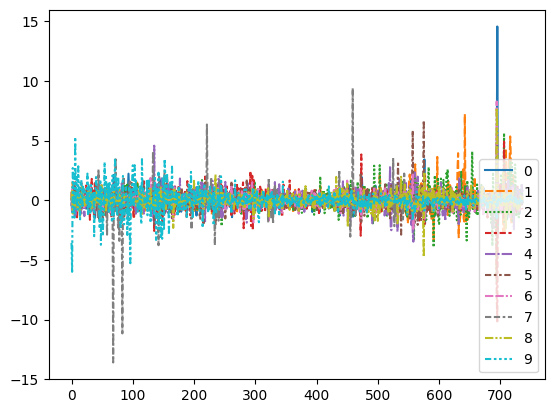

In [32]:
resid = res_vecm.resid
sns.lineplot(resid)

# PCA

In [33]:
pca = PCA()
T = pca.fit_transform(scaled_df)

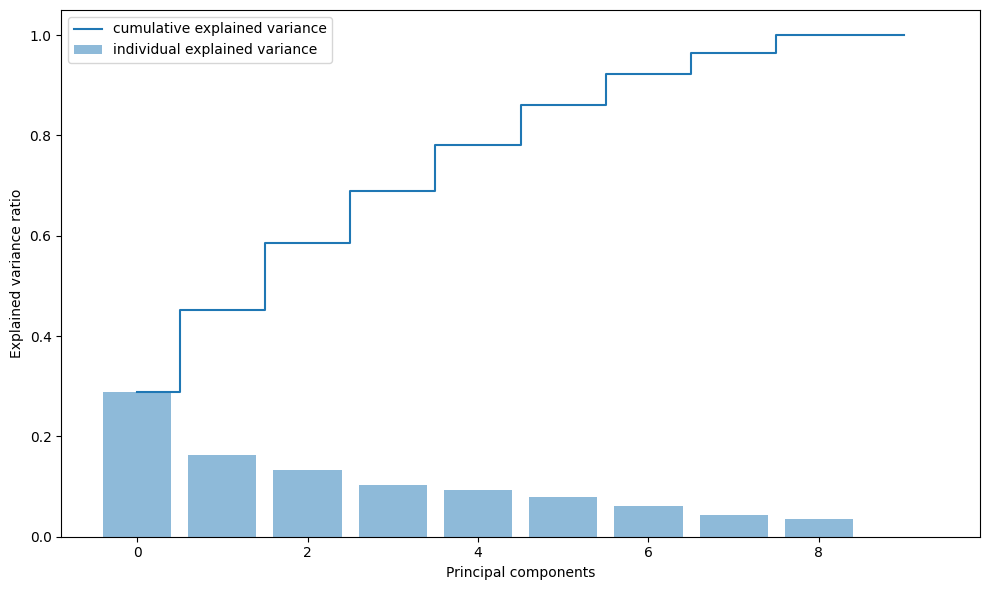

In [34]:
plt.figure(figsize=(10,6))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

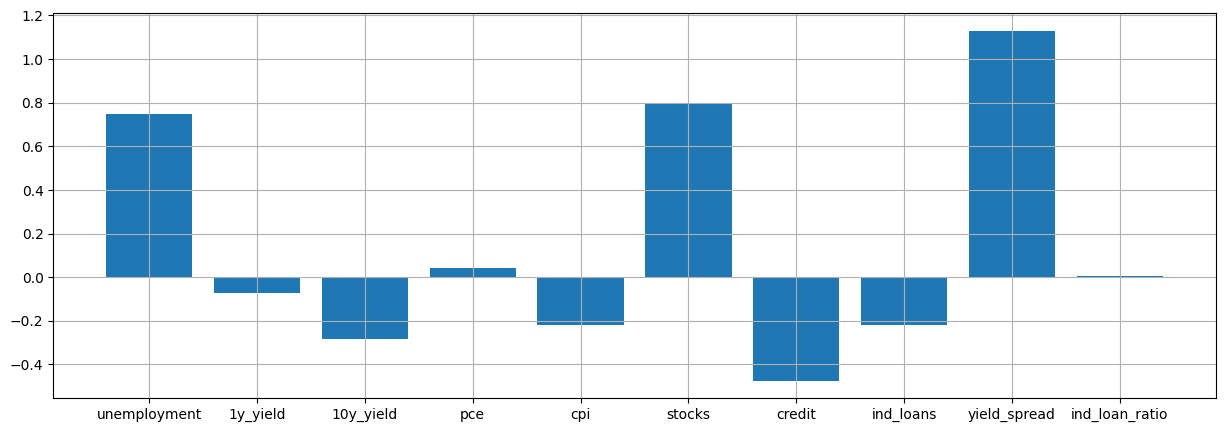

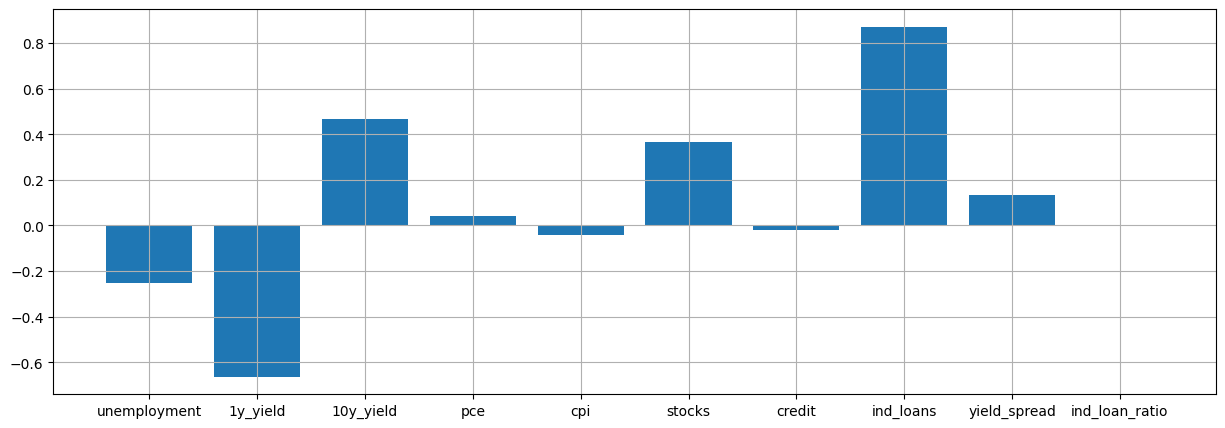

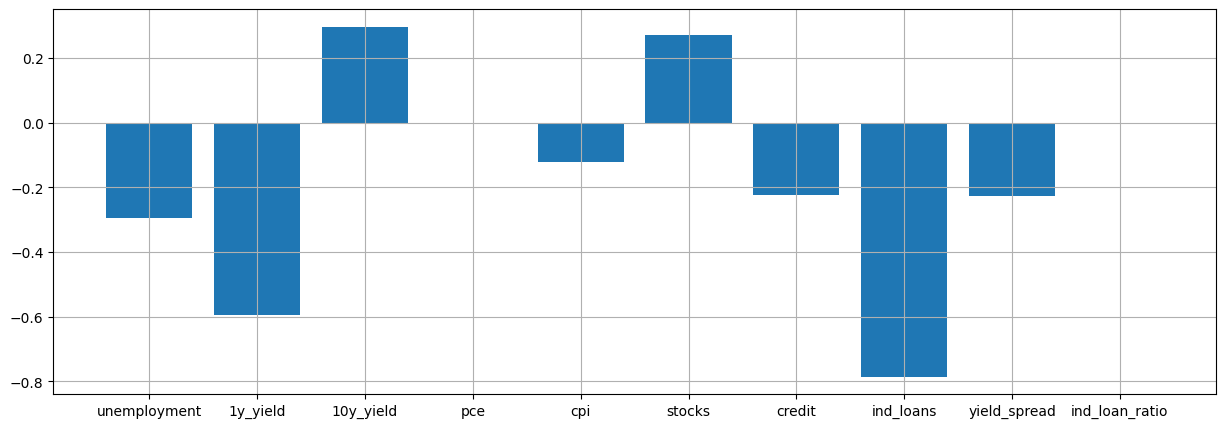

In [35]:
loadings = pca.components_ * np.sqrt(pca.explained_variance_)

plt.figure(figsize=(15,5))
plt.bar(scaled_df.columns,loadings[:,0])
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.bar(scaled_df.columns,loadings[:,1])
plt.grid(True)
plt.show()

plt.figure(figsize=(15,5))
plt.bar(scaled_df.columns,loadings[:,2])
plt.grid(True)
plt.show()

# KPCA

In [36]:
from sklearn.decomposition import KernelPCA

In [37]:
kpca = KernelPCA(kernel='rbf')
KT = kpca.fit_transform(scaled_df)
# Create the scatter plot for the data
fig = px.scatter_3d(x=KT[:, 0], y=KT[:, 1], z=KT[:, 2], color=Z)
fig.update_traces(marker=dict(size=2))
fig.show()

NameError: name 'Z' is not defined

# HMM

In [38]:
from hmmlearn import hmm, vhmm

In [39]:
X = T


# model1 = hmm.GMMHMM(n_components=4, covariance_type='full', n_iter=100000)
model1 = hmm.GMMHMM(n_components=5, covariance_type='diag', n_iter=1000)
model1.fit(X)
# Predict the hidden states corresponding to observed X.
Z = model1.predict(X)
states = pd.unique(Z)
print('States:',states)
print('Model score:',round(model1.score(X)))
# print('Covars', model1.covars_)

States: [2 0 4 3 1]
Model score: -3853


Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate

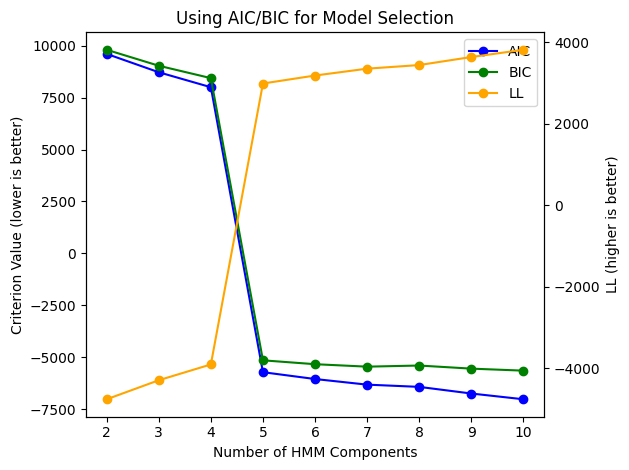

In [40]:
aic = []
bic = []
lls = []
ns = [2, 3, 4, 5, 6,7,8,9,10]
for n in ns:
    best_ll = None
    best_model = None
    for i in range(10):
        h = hmm.GMMHMM(n, n_iter=200, tol=1e-4, random_state=22, covariance_type='diag')
        h.fit(X)
        score = h.score(X)
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(X))
    bic.append(best_model.bic(X))
    lls.append(best_model.score(X))
    
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

Text(0, 0.5, 'State From')

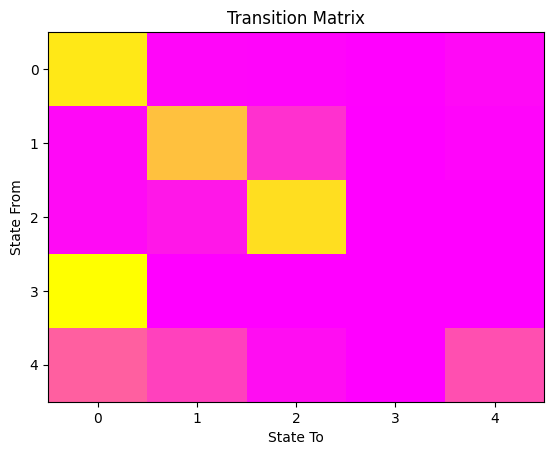

In [41]:
fig, ax = plt.subplots()
ax.imshow(model1.transmat_, aspect='auto', cmap='spring')
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')

In [42]:
model1.means_.shape

(5, 1, 10)

IndexError: index 1 is out of bounds for axis 0 with size 1

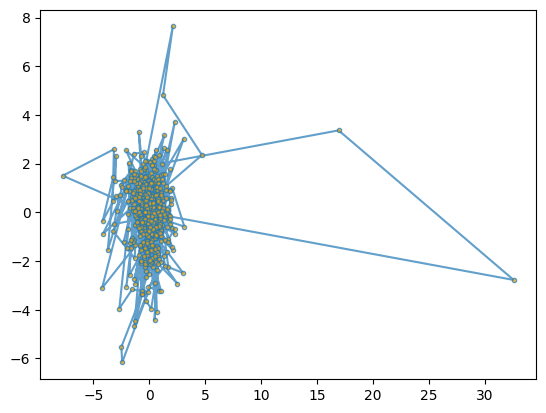

In [43]:
means = model1.means_
# Plot the sampled data
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
        mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    ax.text(m[0], m[1], 'Component %i' % (i + 1),
            size=17, horizontalalignment='center',
            bbox=dict(alpha=.7, facecolor='w'))
ax.legend(loc='best')
fig.show()

In [ ]:
# Create the scatter plot for the data
fig = px.scatter_3d(x=T[:, 0], y=T[:, 1], z=T[:, 2], color=Z)
loadings = pca.components_ * np.sqrt(pca.explained_variance_)
fig.update_traces(marker=dict(size=2))

# # Add the loadings (vectors) to the plot
# for i, feature in enumerate(df.columns):
#     fig.add_trace(
#         go.Scatter3d(
#             x=[0, loadings[i, 0]],
#             y=[0, loadings[i, 1]],
#             z=[0, loadings[i, 2]],
#             mode='lines+text',
#             name=feature,
#             text=[None, feature],
#             textposition='top center'
#         )
#     )

fig.show()

In [ ]:
# Create the scatter plot for the data
fig = px.scatter_3d()
loadings = pca.components_ * np.sqrt(pca.explained_variance_)
fig.update_traces(marker=dict(size=2))

# Add the loadings (vectors) to the plot
for i, feature in enumerate(df.columns):
    fig.add_trace(
        go.Scatter3d(
            x=[0, loadings[i, 0]],
            y=[0, loadings[i, 1]],
            z=[0, loadings[i, 2]],
            mode='lines+text',
            name=feature,
            text=[None, feature],
            textposition='top center'
        )
    )

fig.show()

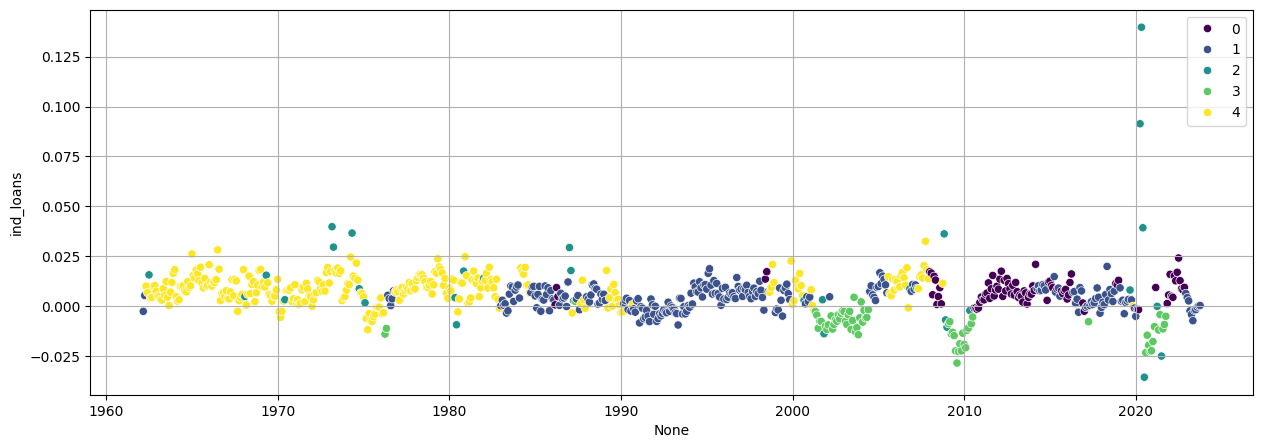

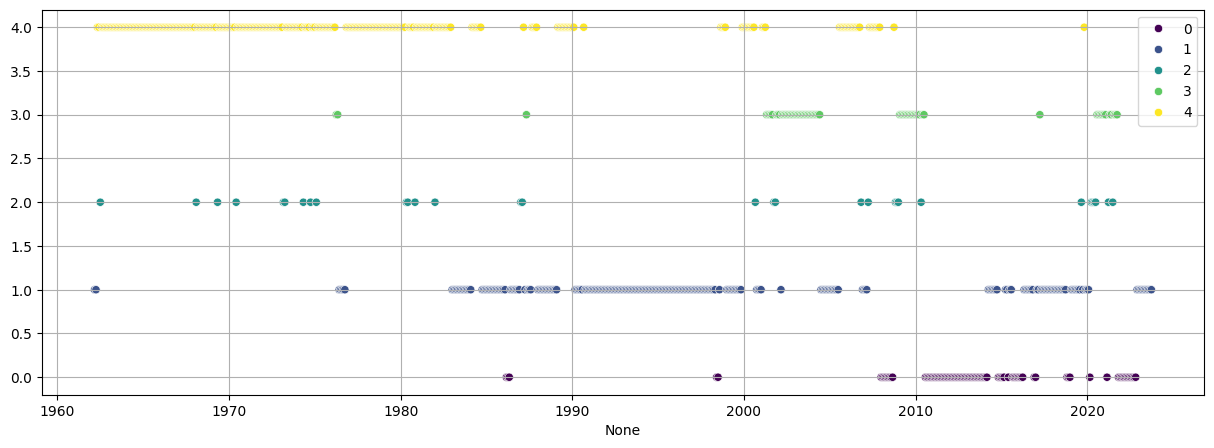

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x=dfp.index, y=dfp['ind_loans'], hue=Z, palette='viridis')
#plt.axhline(0,c='r',linestyle='--')
plt.grid()
plt.show()
plt.figure(figsize=(15,5))
sns.scatterplot(x=scaled_df.index,y=Z,hue=Z,palette='viridis')
plt.grid()
plt.show()

# T-sne

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(3, perplexity=20)
tsne_res = tsne.fit_transform(scaled_df)

# Create the scatter plot for the data
fig = px.scatter_3d(x=tsne_res[:, 0], y=tsne_res[:, 1], z=tsne_res[:, 2],color=Z)
fig.update_traces(marker=dict(size=2))

fig.show()

In [45]:
np.save('states.npy',Z)